In [1]:
import pandas as pd
import numpy as np

In [2]:
from itertools import combinations
from upsetplot import from_memberships
from upsetplot import plot
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

def intersect(data, upset_plot = False):
    """A function that returns all possible distinct intersections and generates an upset plot
    Parameters
    ----------
    data = pandas dataframe
    upset_plot = boolean
    
    Returns
    -------
    df_final = dataframe with list of matches for each comparison and counts
    upset = data formatted to generate upset plots """

    #convert data column names to strings  
    col_names = []
    for i in data.columns:
        col_names.append(str(i))
    data.columns = col_names
    
    #total groups
    n = len(col_names)

    #generate all possible combinations for intersection analysis
    comb_list = []
    for i in range(2,n+1):
        comb_list.append(list(combinations(col_names, i)))

    #find all unique elements and drop na
    unique_elem = []
    tot_elements = []
    for i in col_names:
        unique_elem.append(set(data[i].dropna().to_list()))
    for i in range(len(unique_elem)):
        tot_elements.append([col_names[i], len(unique_elem[i])])
    
    print("Total unique number of items", tot_elements)

    
    #make dictionary for unique elements 
    dict_ = {}
    for i in range(len(col_names)):
        dict_.update({col_names[i]: unique_elem[i]})

    #intersect data, find distinct sets, drop na
    list_intersect = []
    for i in comb_list:
        for j in i:
            if len(j) == 2:
                func_1 = "set(data['{x}'].dropna().to_list()).intersection(data['{y}'].dropna().to_list())".format(x = j[0], y = j[1])
                inter = eval(func_1)
                dict_adj = []
                for i, k in dict_.items():  
                    if i != j[0] and i != j[1]:
                        dict_adj.append(k) 
                for i in dict_adj:
                    unique = inter - i
                    inter = unique
                list_intersect.append([j,list(inter), len(list(inter))])
            else:
                func_2 = "set(data['{x}'].dropna().to_list()).intersection(data['{y}'].dropna().to_list())".format(x = j[0], y = j[1])
                cond = "i != j[0] and i != j[1]"
                for _ in range(2,len(j)):
                    decor_1 = ".intersection(data['{z}'].dropna().to_list())".format(z = j[_])
                    decor_2 = " and i != j[{x}]".format(x = _)
                    func_2 = func_2 + decor_1
                    cond = cond + decor_2
                inter = eval(func_2)
                dict_adj = []
                for i, k in dict_.items():  
                    if eval(cond):
                        dict_adj.append(k) 
                for i in dict_adj:
                    unique = inter - i
                    inter = unique
                list_intersect.append([j,list(inter), len(list(inter))])

    #obtain elements found only in individual datasets
    for j in range(len(col_names)):
        for i in list_intersect:
            if col_names[j] in set(i[0]):
                unique_elem[j] = unique_elem[j] - set(i[1]) 
        unique_elem[j] = list(unique_elem[j])

    #create dataframe for elements found only in individual datasets
    df_1 = pd.DataFrame(col_names)
    df_1[1] = unique_elem
    df_1[2] = [len(i) for i in unique_elem]

    #combine intersect data and unique elements found within individual sets
    df_2 = pd.DataFrame(list_intersect)
    df_3 = pd.concat([df_1,df_2])
    df_3.columns = ["Intersection", "Match", "Counts"]
    df_3 = df_3.reset_index(drop = True)
    
    #generate data structure for upset plot
    upset = df_3.drop("Match", axis=1)
    lst_1 = df_3["Intersection"].to_list()
    lst_2 = df_3["Intersection"].to_list()
    for i in range(len(col_names)):
        lst_1[i] = [lst_2[i]]
    upset = from_memberships(
    lst_1, data=upset["Counts"])
    
    #make upset plot
    if upset_plot == True:
        plot(upset)
    
    return df_3, upset

<img src="./images/intersection.png" width="500" height="800">

This function will find distinct sets between groups of infinite size. The function will return groups being compared, a list of matches, and the total number of unique elements. This function will be useful in proteomic and transcriptomic analysis to find distinct matches amongst all combinations of groups. In addition, an upset plot will be generated and the corresponding UpSet plot data format used will be outputed.

# Test 1 (Small Dataset)

In [3]:
arr = np.array([["a","b","c","d"],
         ["a","e","f","d"],
         ["a","c","z","l"]])

In [4]:
#using integer column names
df = pd.DataFrame(arr.T)
df.columns = [0,1,2] 

In [5]:
df

,0,1,2
0,a,a,a
1,b,e,c
2,c,f,z
3,d,d,l


Total unique number of items [['0', 4], ['1', 4], ['2', 4]]


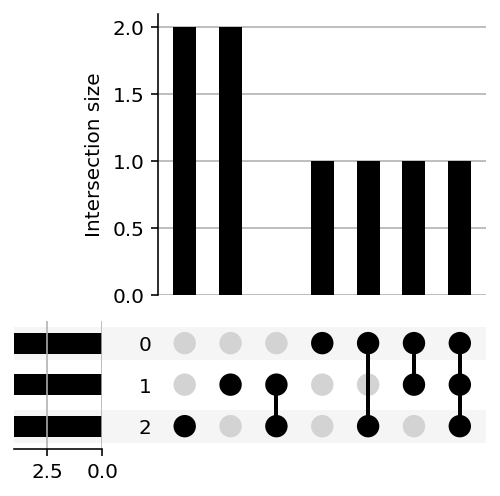

In [6]:
data,upset = intersect(df, upset_plot = True)
#plt.savefig("upset.svg")

In [7]:
data

,Intersection,Match,Counts
0,0,[b],1
1,1,"[e, f]",2
2,2,"[l, z]",2
3,"(0, 1)",[d],1
4,"(0, 2)",[c],1
5,"(1, 2)",[],0
6,"(0, 1, 2)",[a],1


In [8]:
upset

0      1      2    
True   False  False    1
False  True   False    2
       False  True     2
True   True   False    1
       False  True     1
False  True   True     0
True   True   True     1
Name: Counts, dtype: int64

# Test 2 (Small Dataset)

In [9]:
arr = np.array([["a","b","c","d"],
                ["a","e","f","d"],
                ["a","c","z","l"],
                ["x","c","w","l"],
                ["a","c","z","y"]])

In [10]:
df = pd.DataFrame(arr.T)
df.columns = ["a","b","c", "d", "e"] 

In [11]:
df

,a,b,c,d,e
0,a,a,a,x,a
1,b,e,c,c,c
2,c,f,z,w,z
3,d,d,l,l,y


Total unique number of items [['a', 3], ['b', 3], ['c', 3], ['d', 3], ['e', 3]]


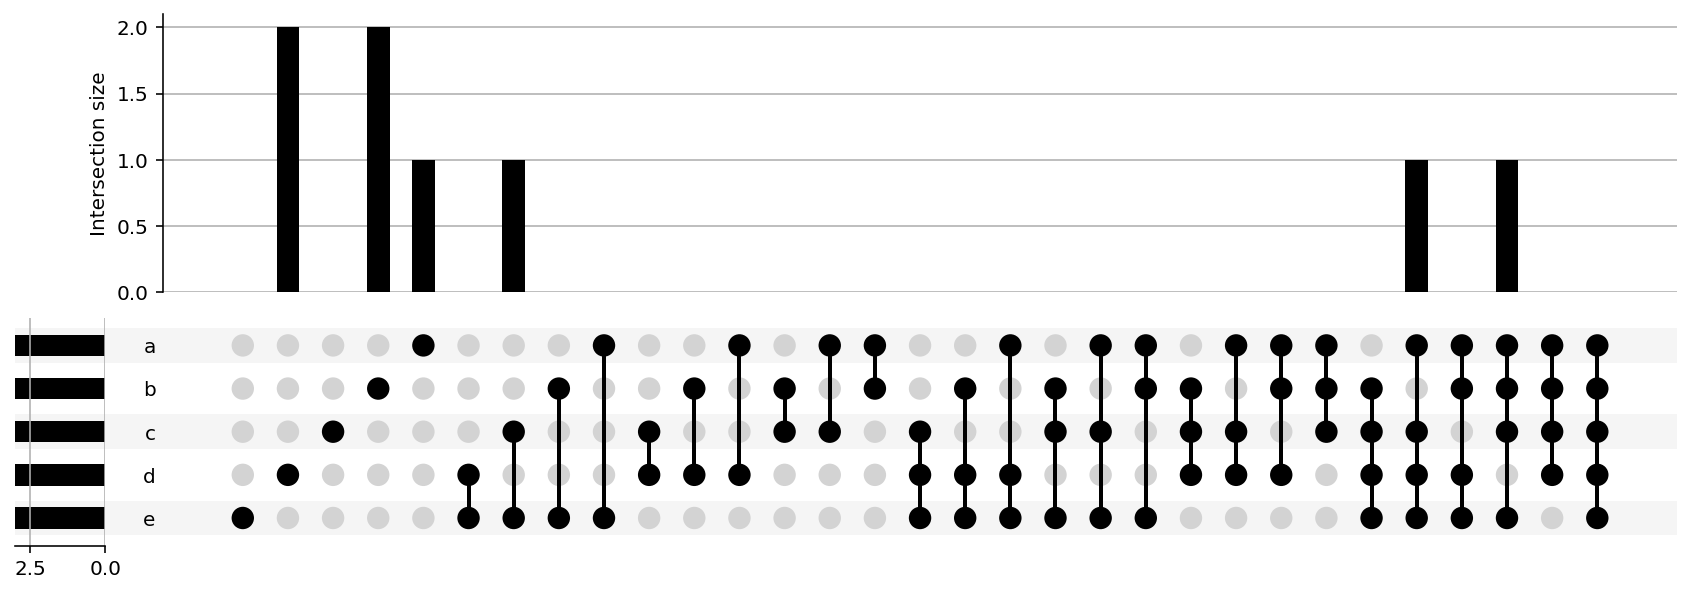

In [12]:
data,upset = intersect(df[0:3], upset_plot = True)

In [13]:
data

,Intersection,Match,Counts
0,a,[b],1
1,b,"[e, f]",2
2,c,[],0
3,d,"[w, x]",2
4,e,[],0
5,"(a, b)",[],0
6,"(a, c)",[],0
7,"(a, d)",[],0
8,"(a, e)",[],0
9,"(b, c)",[],0


In [14]:
upset

a      b      c      d      e    
True   False  False  False  False    1
False  True   False  False  False    2
       False  True   False  False    0
              False  True   False    2
                     False  True     0
True   True   False  False  False    0
       False  True   False  False    0
              False  True   False    0
                     False  True     0
False  True   True   False  False    0
              False  True   False    0
                     False  True     0
       False  True   True   False    0
                     False  True     1
              False  True   True     0
True   True   True   False  False    0
              False  True   False    0
                     False  True     0
       False  True   True   False    0
                     False  True     0
              False  True   True     0
False  True   True   True   False    0
                     False  True     0
              False  True   True     0
       False  True   True   Tr

# Test 3 (Medium Dataset)

In [15]:
arr_1 = np.round(np.random.normal(loc = 10, scale = 2, size = 1000), 2)
arr_2 = np.round(np.random.normal(loc = 10, scale = 2, size = 1000), 2)
arr_3 = np.round(np.random.normal(loc = 10, scale = 2, size = 1000), 2)

In [16]:
df = pd.DataFrame(arr_1)
df[1] = arr_2
df[2] = arr_3

df.columns = ["Exp1", "Exp2", "Exp3"]

In [17]:
df

,Exp1,Exp2,Exp3
0,10.17,11.31,8.92
1,7.07,12.61,8.39
2,12.64,11.26,7.73
3,8.03,10.87,11.52
4,8.13,11.81,11.74
...,...,...,...
995,10.36,12.79,10.15
996,9.10,12.75,9.82
997,8.37,8.31,8.89
998,8.32,10.90,8.95


Total unique number of items [['Exp1', 554], ['Exp2', 571], ['Exp3', 553]]


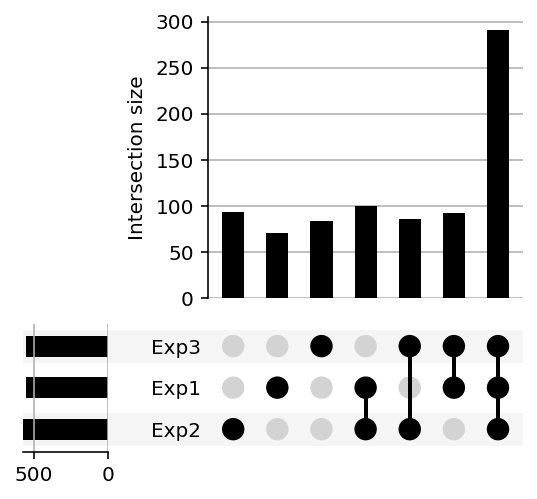

In [18]:
data,upset = intersect(df, upset_plot = True)

In [19]:
data

,Intersection,Match,Counts
0,Exp1,"[4.33, 5.0, 5.44, 7.0, 5.47, 6.22, 9.9, 11.97,...",71
1,Exp2,"[4.98, 5.58, 5.9, 6.5, 8.11, 4.86, 5.72, 11.25...",94
2,Exp3,"[4.18, 5.92, 6.44, 6.19, 5.5, 5.25, 6.75, 7.25...",84
3,"(Exp1, Exp2)","[4.43, 5.75, 6.94, 7.51, 7.75, 8.5, 10.87, 11....",100
4,"(Exp1, Exp3)","[6.41, 7.97, 7.14, 8.03, 8.39, 11.24, 10.6, 11...",92
5,"(Exp2, Exp3)","[5.16, 6.15, 7.16, 7.73, 8.25, 9.35, 8.47, 11....",86
6,"(Exp1, Exp2, Exp3)","[6.7, 7.59, 8.92, 9.69, 10.53, 11.18, 12.17, 8...",291


In [20]:
upset

Exp1   Exp2   Exp3 
True   False  False     71
False  True   False     94
       False  True      84
True   True   False    100
       False  True      92
False  True   True      86
True   True   True     291
Name: Counts, dtype: int64

# Test 4 (Medium High Dataset)

In [21]:
arr_1 = np.round(np.random.normal(loc = 10, scale = 2, size = 10000), 2)
arr_2 = np.round(np.random.normal(loc = 10, scale = 2, size = 10000), 2)
arr_3 = np.round(np.random.normal(loc = 10, scale = 2, size = 10000), 2)

In [22]:
df = pd.DataFrame(arr_1)
df[1] = arr_2
df[2] = arr_3

df.columns = ["Exp1", "Exp2", "Exp3"]

In [23]:
df

,Exp1,Exp2,Exp3
0,10.76,14.01,8.78
1,10.86,9.62,6.15
2,6.14,9.60,8.40
3,13.20,9.44,14.01
4,7.84,12.30,10.07
...,...,...,...
9995,8.18,12.20,10.16
9996,10.95,10.00,6.94
9997,10.80,9.88,8.40
9998,10.34,13.92,9.16


Total unique number of items [['Exp1', 1069], ['Exp2', 1043], ['Exp3', 1071]]


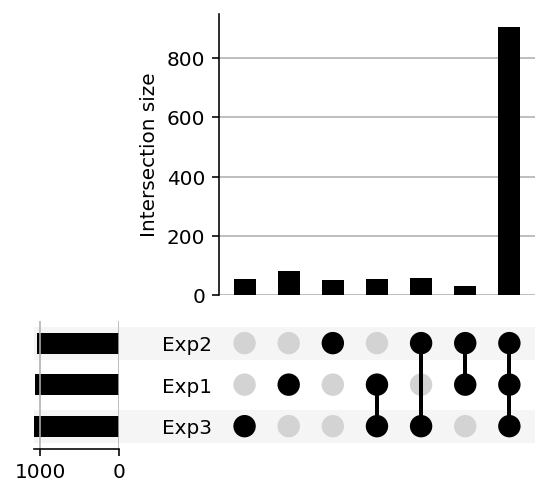

In [24]:
data,upset = intersect(df, upset_plot = True)

In [25]:
data

,Intersection,Match,Counts
0,Exp1,"[2.78, 3.16, 4.0, 4.25, 4.47, 4.26, 3.27, 3.52...",81
1,Exp2,"[3.26, 4.66, 5.0, 4.63, 4.13, 4.85, 4.6, 5.85,...",52
2,Exp3,"[2.99, 3.66, 4.52, 3.5, 4.94, 5.19, 4.41, 3.38...",56
3,"(Exp1, Exp2)","[3.98, 4.61, 4.91, 4.23, 5.83, 4.55, 4.99, 4.9...",30
4,"(Exp1, Exp3)","[3.34, 4.98, 5.5, 5.25, 5.44, 4.88, 5.17, 4.35...",54
5,"(Exp2, Exp3)","[3.84, 4.5, 5.72, 6.15, 5.22, 6.44, 5.35, 5.6,...",57
6,"(Exp1, Exp2, Exp3)","[4.78, 5.69, 6.22, 7.58, 7.76, 8.78, 10.25, 8....",904


In [26]:
upset

Exp1   Exp2   Exp3 
True   False  False     81
False  True   False     52
       False  True      56
True   True   False     30
       False  True      54
False  True   True      57
True   True   True     904
Name: Counts, dtype: int64

# Test 5 (Unequal length dataset)

In [27]:
arr_1 = np.round(np.random.normal(loc = 10, scale = 2, size = 800), 2)
arr_2 = np.round(np.random.normal(loc = 10, scale = 2, size = 1000), 2)
arr_3 = np.round(np.random.normal(loc = 10, scale = 2, size = 1200), 2)

In [28]:
df_1 = pd.DataFrame(arr_1)
df_2 = pd.DataFrame(arr_2)
df_3 = pd.DataFrame(arr_3)

In [29]:
unequal = pd.concat([df_1, df_2, df_3],axis=1)
unequal.columns = ["Exp1", "Exp2", "Exp3"]

In [30]:
unequal

,Exp1,Exp2,Exp3
0,9.22,9.68,11.84
1,10.31,10.15,11.80
2,11.79,11.54,6.39
3,6.64,11.69,6.12
4,8.83,7.72,6.26
...,...,...,...
1195,NaN,NaN,13.73
1196,NaN,NaN,9.33
1197,NaN,NaN,11.44
1198,NaN,NaN,7.65


Total unique number of items [['Exp1', 480], ['Exp2', 552], ['Exp3', 615]]


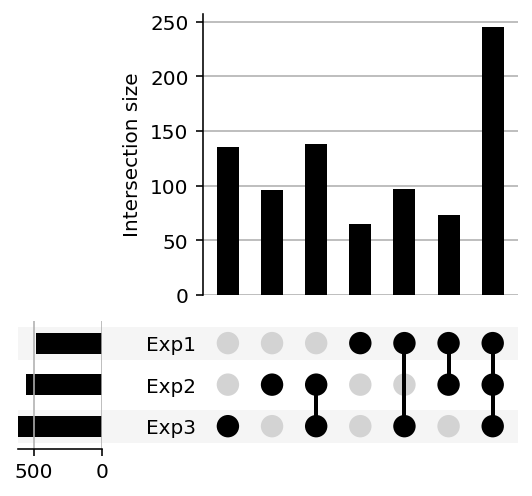

In [31]:
data,upset = intersect(unequal, upset_plot = True)

In [32]:
data

,Intersection,Match,Counts
0,Exp1,"[3.44, 4.25, 4.96, 4.48, 6.64, 5.72, 6.22, 6.4...",65
1,Exp2,"[2.71, 3.26, 4.9, 5.97, 6.57, 6.75, 7.22, 8.19...",96
2,Exp3,"[3.74, 4.98, 5.5, 5.54, 6.12, 5.25, 7.25, 10.2...",135
3,"(Exp1, Exp2)","[8.78, 5.68, 6.84, 7.94, 6.5, 8.75, 9.78, 9.5,...",73
4,"(Exp1, Exp3)","[5.88, 6.88, 6.39, 6.26, 7.5, 7.75, 10.0, 11.7...",97
5,"(Exp2, Exp3)","[4.45, 5.7, 6.13, 6.53, 8.11, 8.0, 10.69, 10.1...",138
6,"(Exp1, Exp2, Exp3)","[6.73, 7.93, 8.4, 8.03, 10.5, 11.3, 10.44, 11....",245


In [33]:
upset

Exp1   Exp2   Exp3 
True   False  False     65
False  True   False     96
       False  True     135
True   True   False     73
       False  True      97
False  True   True     138
True   True   True     245
Name: Counts, dtype: int64

This function passed all tests. It is able to handle large datasets pretty well and return the proper number of matches and counts. A proper pytest will be developed later.

# Using package

In [34]:
import gen_analysis as gn

Total unique number of items [['Exp1', 480], ['Exp2', 552], ['Exp3', 615]]


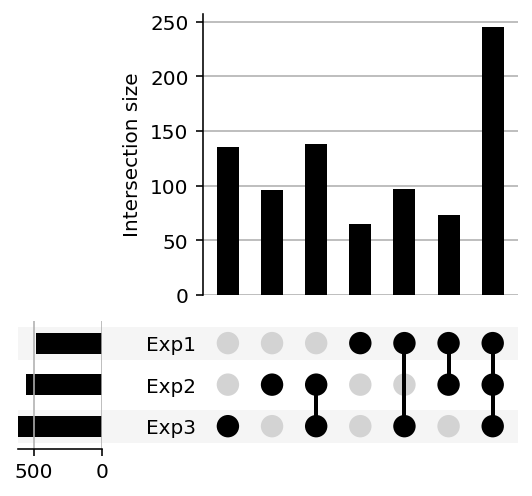

In [35]:
data, upset = gn.intersect(unequal, upset_plot=True)

In [36]:
data

,Intersection,Match,Counts
0,Exp1,"[3.44, 4.25, 4.96, 4.48, 6.64, 5.72, 6.22, 6.4...",65
1,Exp2,"[2.71, 3.26, 4.9, 5.97, 6.57, 6.75, 7.22, 8.19...",96
2,Exp3,"[3.74, 4.98, 5.5, 5.54, 6.12, 5.25, 7.25, 10.2...",135
3,"(Exp1, Exp2)","[8.78, 5.68, 6.84, 7.94, 6.5, 8.75, 9.78, 9.5,...",73
4,"(Exp1, Exp3)","[5.88, 6.88, 6.39, 6.26, 7.5, 7.75, 10.0, 11.7...",97
5,"(Exp2, Exp3)","[4.45, 5.7, 6.13, 6.53, 8.11, 8.0, 10.69, 10.1...",138
6,"(Exp1, Exp2, Exp3)","[6.73, 7.93, 8.4, 8.03, 10.5, 11.3, 10.44, 11....",245


In [37]:
upset

Exp1   Exp2   Exp3 
True   False  False     65
False  True   False     96
       False  True     135
True   True   False     73
       False  True      97
False  True   True     138
True   True   True     245
Name: Counts, dtype: int64

In [38]:
#numbers add up for exp 1
65+73+97+245

480

In [39]:
#double check random values to see if it is true
i, c = np.where(unequal.values == 4.25)
np.unique(unequal.columns[c])

array(['Exp1'], dtype=object)

In [40]:
#double check random values to see if it is true
i, c = np.where(unequal.values == 2.71)
np.unique(unequal.columns[c])

array(['Exp2'], dtype=object)

In [41]:
#double check random values to see if it is true
i, c = np.where(unequal.values == 8.78)
np.unique(unequal.columns[c])

array(['Exp1', 'Exp2'], dtype=object)

In [42]:
#double check random values to see if it is true
i, c = np.where(unequal.values == 10.44)
np.unique(unequal.columns[c])

array(['Exp1', 'Exp2', 'Exp3'], dtype=object)

In [43]:
#double check random values to see if it is true
i, c = np.where(unequal.values == 7.5)
np.unique(unequal.columns[c])

array(['Exp1', 'Exp3'], dtype=object)

Everything looks good!